# Analysing the MuSe-Perception 2024 Labels

According to the baseline paper, the videos in the dataset are labeled according to the Dual Perception Model, which states that there are two fundamental dimensions of content in social cognition: agency and communion. Whilst agency is related to self-perception, communality is linked to the perception of others. In the Dual Perception Model paper, the authors state that the two dimensions are logically independent, and that communal content is more relevant to social perception than agentic content.

The dataset contains the following labels:

**Agency based labels:**
- `aggressiveness`
- `arrogance`
- `assertiveness`
- `confidence`
- `dominance`
- `independence`
- `leadership`
- `risk_taking`

**Communality based labels:**
- `collaboration`
- `enthusiasm`
- `friendliness`
- `good naturedness`
- `kindness`
- `likability`
- `sincerity`
- `warmth`

The baseline paper trains a single model for each variable. Although this allows to train expert systems on each of the variables, the cost is high and the relationship between each of the dimensions is not explored.

The hypothesis for this study is that there are intrinsic relationships between the labels that can be leveraged in order to build models that are both more efficient and more effective.

The objectives are:

* Analyse the data and search for errors.
* Analyse the relationships between the labels, exploring possible correlations and dependencies.
* Generate lower dimensional representations of the labels that can be used to train models that are more efficient and effective.

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_FOLDER = "/mnt/thau03a/datasets/c1_muse_perception"

First of all, a quick sanity check.

In [6]:
labels = pd.read_csv(f"{DATA_FOLDER}/labels.csv")
print(labels.head())
print(labels.shape)
print(labels.describe())

   subj_id  aggressive  arrogant  attractive  charismatic  competitive  \
0        0         NaN       NaN         NaN          NaN          NaN   
1        1         NaN       NaN         NaN          NaN          NaN   
2        2      0.4940    0.4524      0.5595       0.6667       0.6905   
3        3      0.3944    0.3000      0.5000       0.4611       0.5778   
4        6         NaN       NaN         NaN          NaN          NaN   

   dominant  enthusiastic  expressive  friendly  ...   naive  assertiv  \
0       NaN           NaN         NaN       NaN  ...     NaN       NaN   
1       NaN           NaN         NaN       NaN  ...     NaN       NaN   
2    0.6429        0.6964      0.8333    0.5774  ...  0.2798    0.7798   
3    0.4611        0.4667      0.4444    0.5778  ...  0.2333    0.5667   
4       NaN           NaN         NaN       NaN  ...     NaN       NaN   

   confident  independent    risk  sincere  collaborative    kind    warm  \
0        NaN          NaN     NaN

In [7]:
labels = labels.dropna()
print(labels.shape)

(117, 22)


In [8]:
labels.columns

Index(['subj_id', 'aggressive', 'arrogant', 'attractive', 'charismatic',
       'competitive', 'dominant', 'enthusiastic', 'expressive', 'friendly',
       'leader_like', 'likeable', 'naive', 'assertiv', 'confident',
       'independent', 'risk', 'sincere', 'collaborative', 'kind', 'warm',
       'good_natured'],
      dtype='object')

The labels are contained in a csv file with a row per subject. The test subjects are also included, with NaN values for the labels.

The first interesting aspect of the data is that there are 5 labels that are not originally presented in the paper nor part of the evaluation process. These are:

- `attractiveness`
- `naive`
- `charismatic`
- `expressive`
- `competitive`

It is unclear wether these should be taken into account as regression labels or if they can be used as features. We will leave them apart at training and evaluation stages by now.

In [3]:
partitions = pd.read_csv(f"{DATA_FOLDER}/metadata/partition.csv")
partitions.head()

,Id,Partition
0,0,test
1,1,test
2,2,train
3,3,train
4,6,test


In [5]:
partitions.Partition.value_counts()

Partition
test     60
train    59
devel    58
Name: count, dtype: int64

The `partitions`file contains the relation partition-subject for the dataset. There are 59 train subjects, 58 devel subjects and 60 test subjects.

In [9]:
# train labels are those whose subj_id (which appears as Id in the partition csv) has the train value in the Partition column of the partition csv
train_labels = labels[labels["subj_id"].isin(partitions[partitions["Partition"] == "train"]["Id"])]
print(train_labels.shape)

(59, 22)


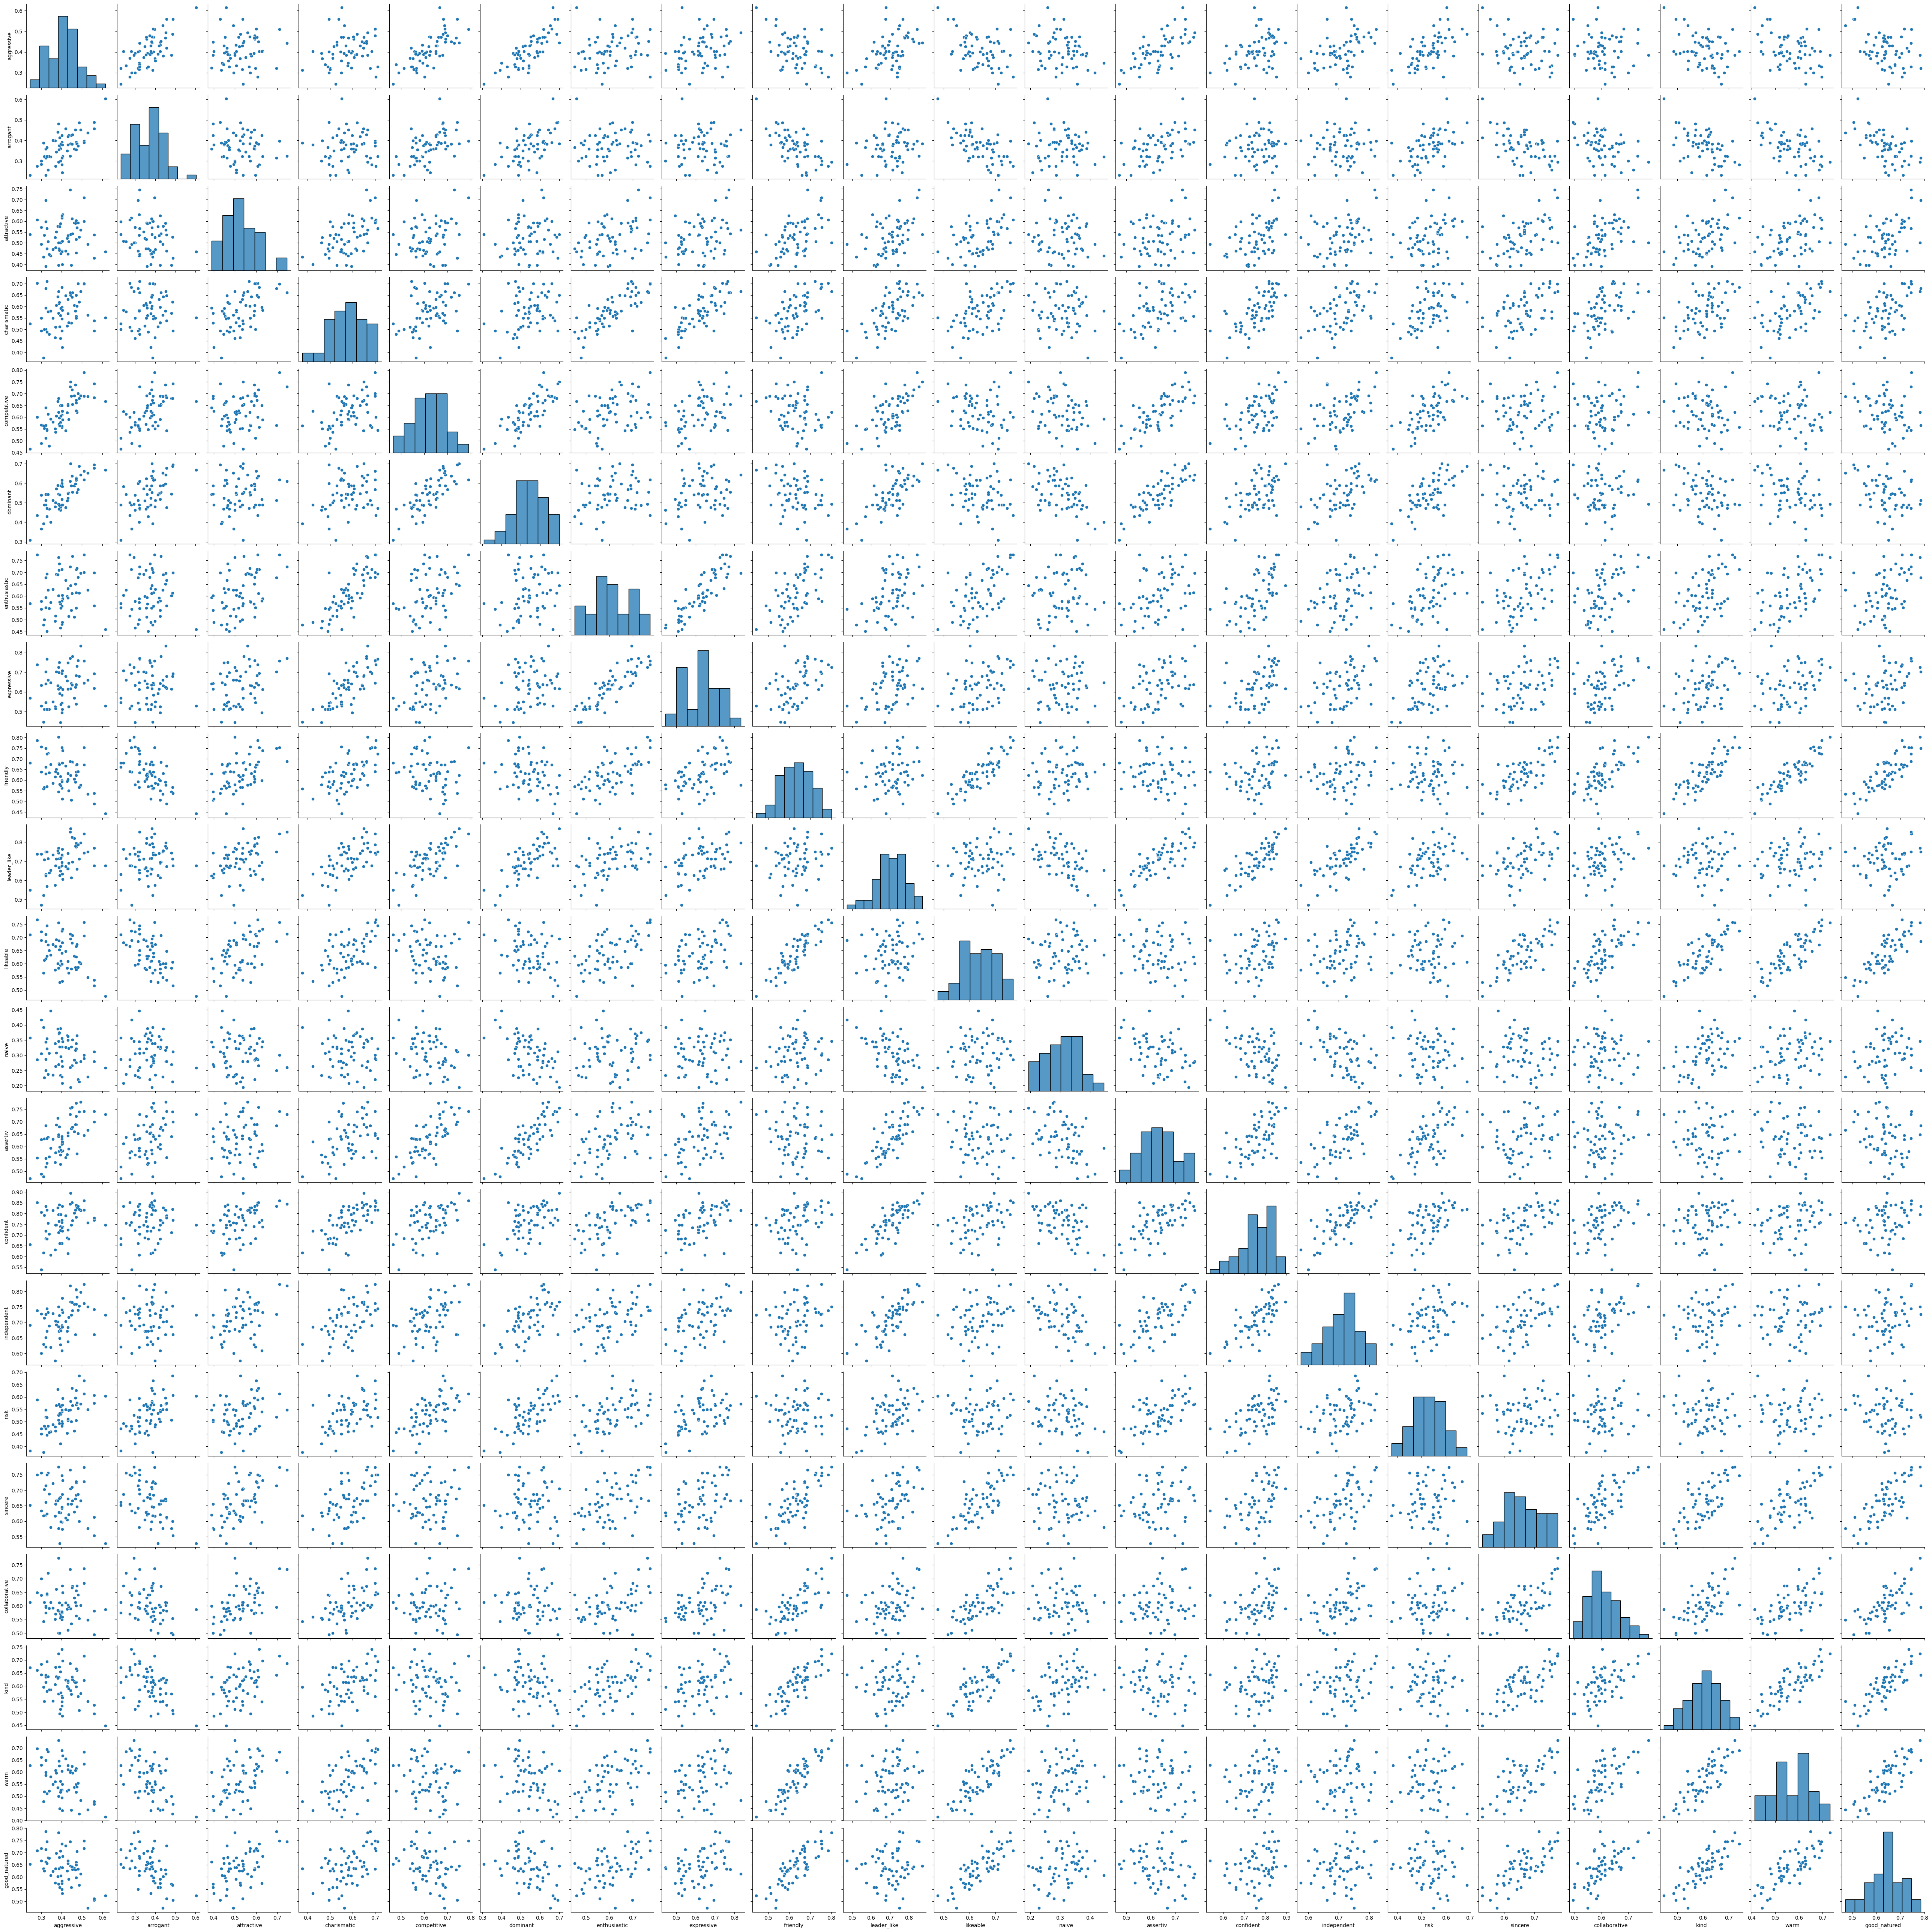

In [10]:
import seaborn as sns

sns.pairplot(train_labels.drop('subj_id', axis=1))

Although very extensive and difficult to analyse, the pair plot above shows a relationship between each of the dimensions in the dataset.
Regarding the distributions, each label has a slightly different one and there are no clearly observed anomalies.
However, the scatter plots reveal clear linear dependencies between some of the variables. A correlation plot should be able to show this more clearly.

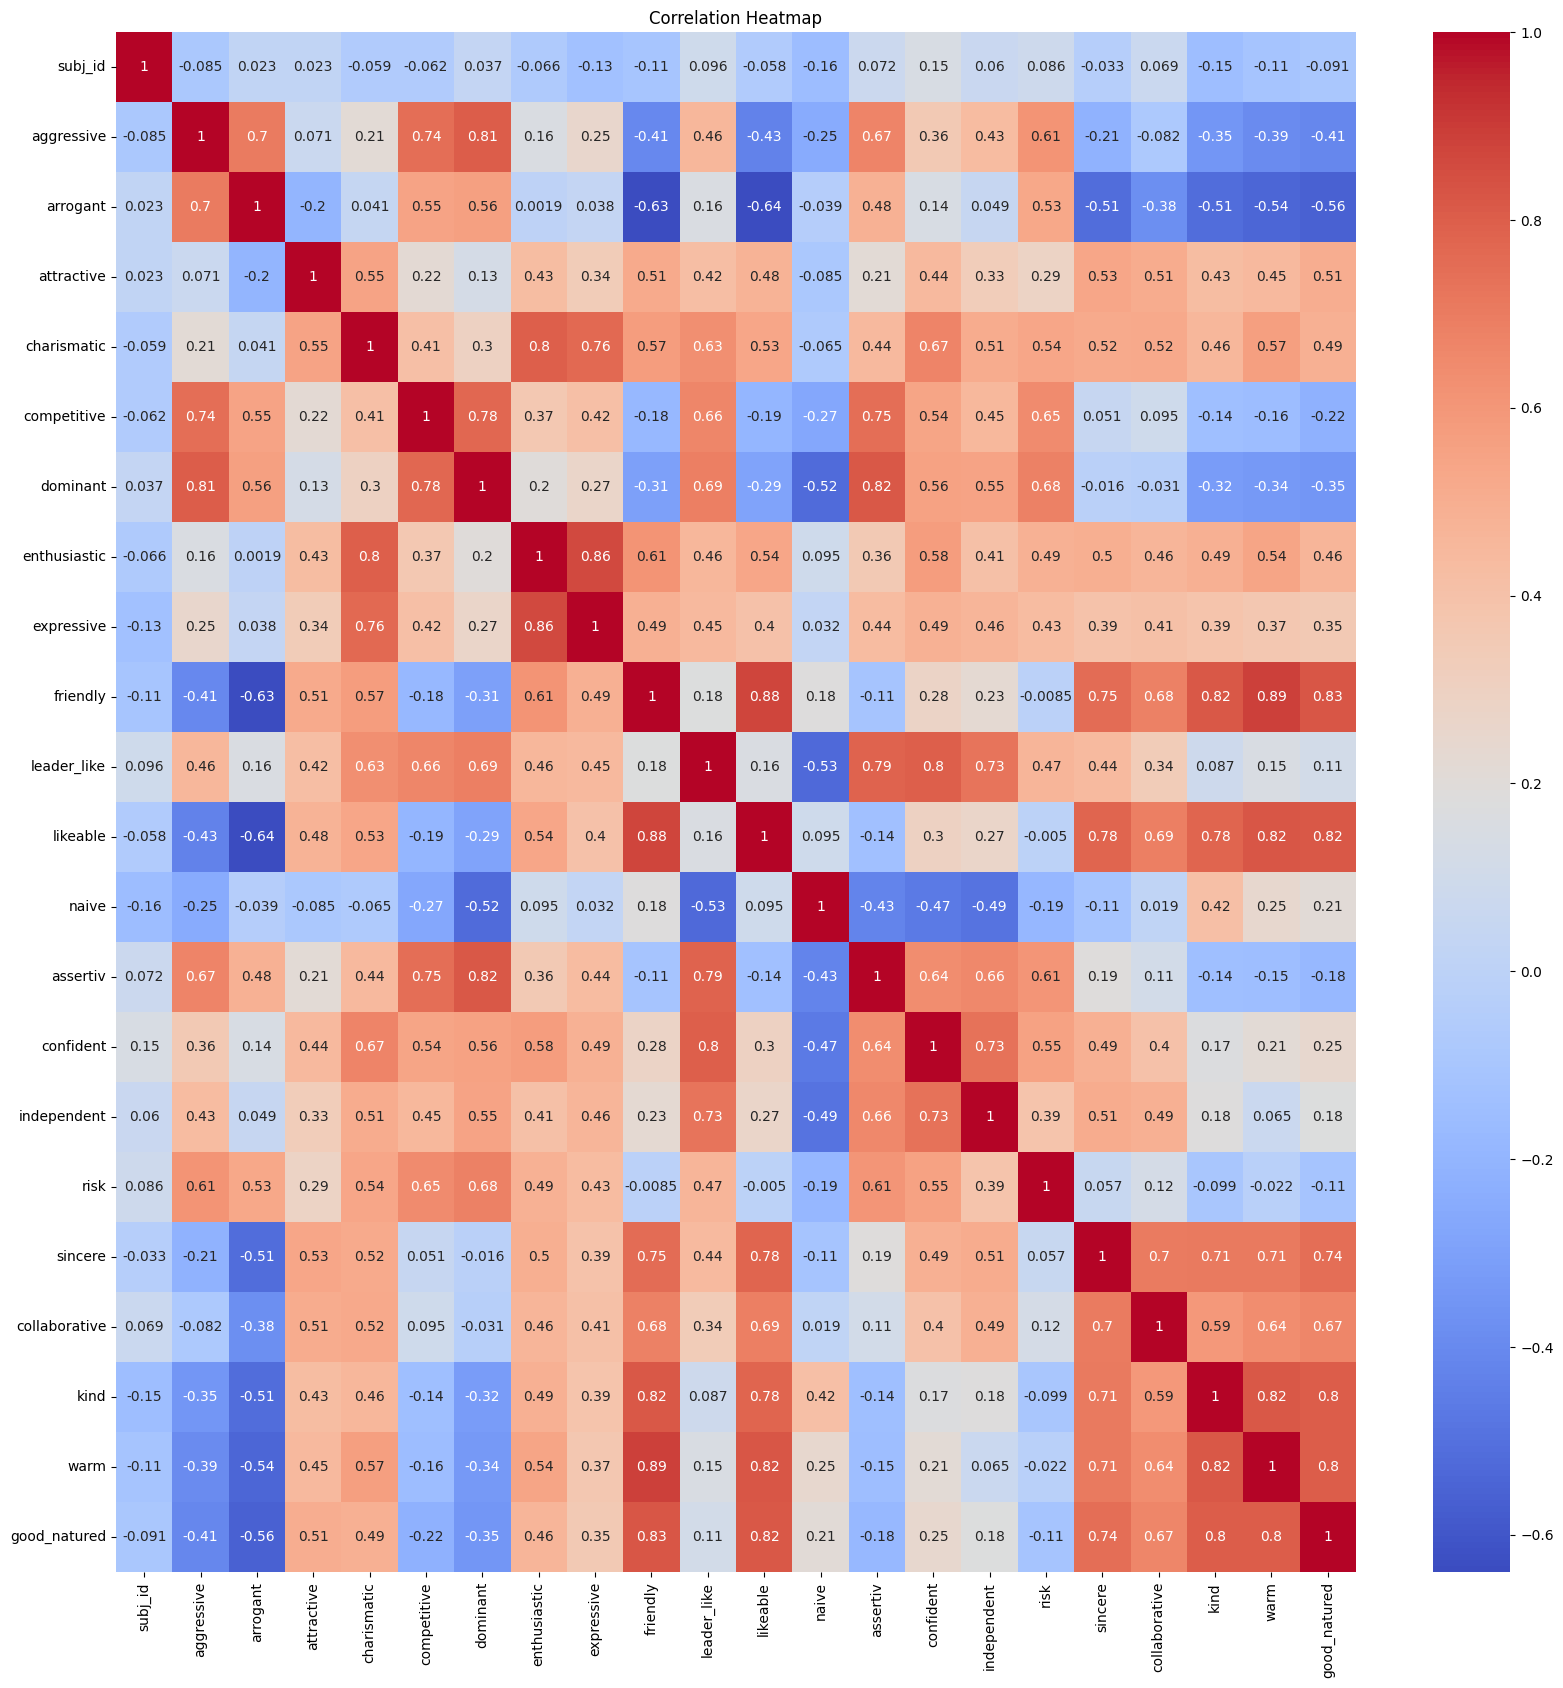

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(train_labels.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

As predicted, there are sets of features that are highly correlated. In particular, there is a high correlation between the `sincere`, `collaborative`, `warm` and `good_natured` labels, which coincidentally are all communality based. Also, some agency based labels seem to be negatively correlated with communality based labels, such as `arrogant` and `aggressive`.

We can remove clutter by plotting just the statistically significant correlations with $p<0.001$.

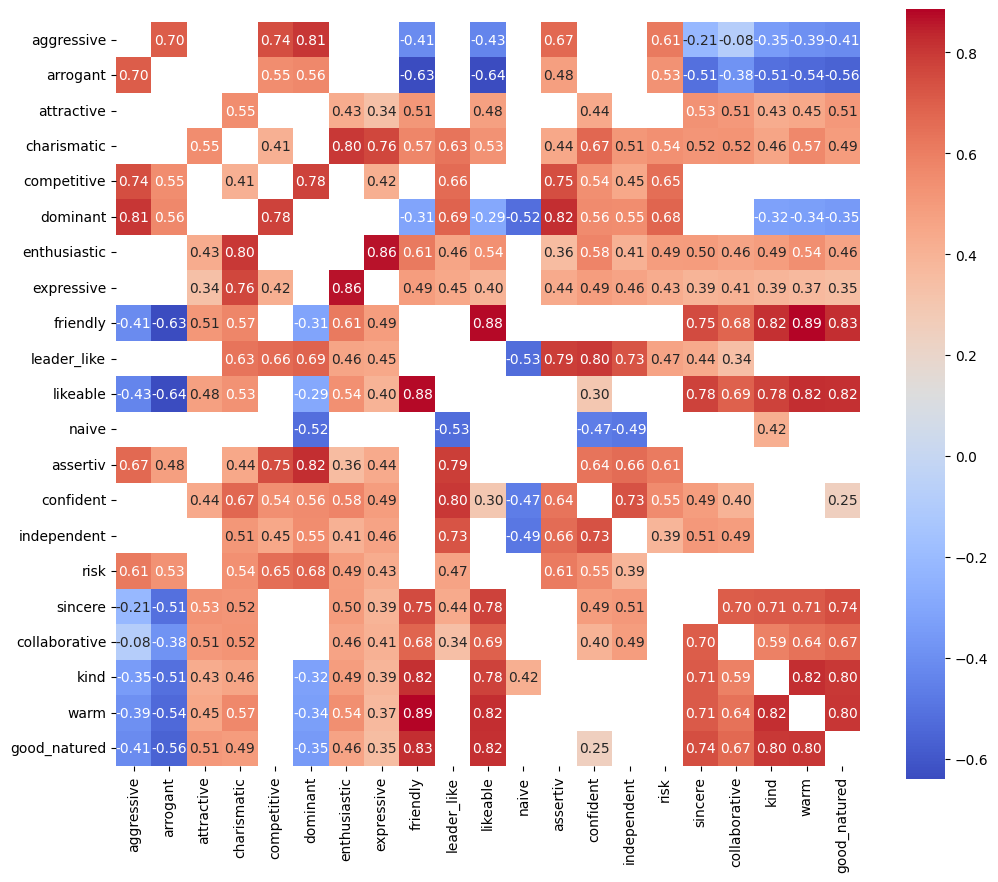

In [12]:
from scipy.stats import pearsonr

corr = train_labels.drop(columns="subj_id").corr()

p_values = pd.DataFrame(index=corr.columns, columns=corr.columns)

for i in corr.columns:
    for j in corr.columns:
        if i != j:
            _, p = pearsonr(labels[i], labels[j])
            p_values.loc[i, j] = p

mask = np.where(p_values < 0.001, True, False)

# Apply the mask to the correlation DataFrame
masked_corr = corr.where(mask)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(masked_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

There are several statistically significant correlations between the labels. This goes in favour of the hypothesis that there exist exploitable dependencies between them.

In [13]:
variable_to_dimension = {
    "aggressive": "agentic",
    "arrogant": "agentic",
    "attractive": "unknown",
    "charismatic": "unknown",
    "competitive": "unknown",
    "dominant": "agentic",
    "enthusiastic": "communal",
    "expressive": "unknown",
    "friendly": "communal",
    "leader_like": "agentic",
    "likeable": "communal",
    "naive": "unknown",
    "assertiv": "agentic",
    "confident": "agentic",
    "independent": "agentic",
    "risk": "agentic",
    "sincere": "communal",
    "collaborative": "communal",
    "kind": "communal",
    "warm": "communal",
    "good_natured": "communal",
}

We can check how the variance is distributed among the variables using Principal Components. This way we can see if the first components are key in explaining the label data.

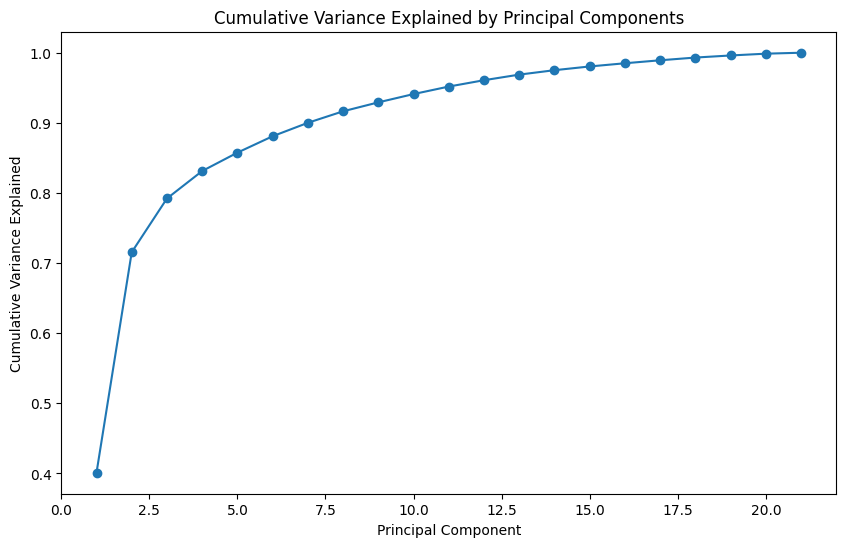

In [14]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Create a PCA object
pca = PCA(n_components=21)

# Fit the PCA on the data
pca.fit(train_labels.drop(columns="subj_id"))

# Get the variance explained by each component
variance_explained = pca.explained_variance_ratio_

# Calculate the cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot the cumulative variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, 22), cumulative_variance_explained, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.show()

The two first PC amount to more than 70% of the variance. This complies with the theorical idea of the labels being a subset of two fundamental dimensions. However, there is still a non-negligible amount of variance that is not explained by the first two components.

We can also check the loadings of the first two components to see which labels are more relevant in each of them.

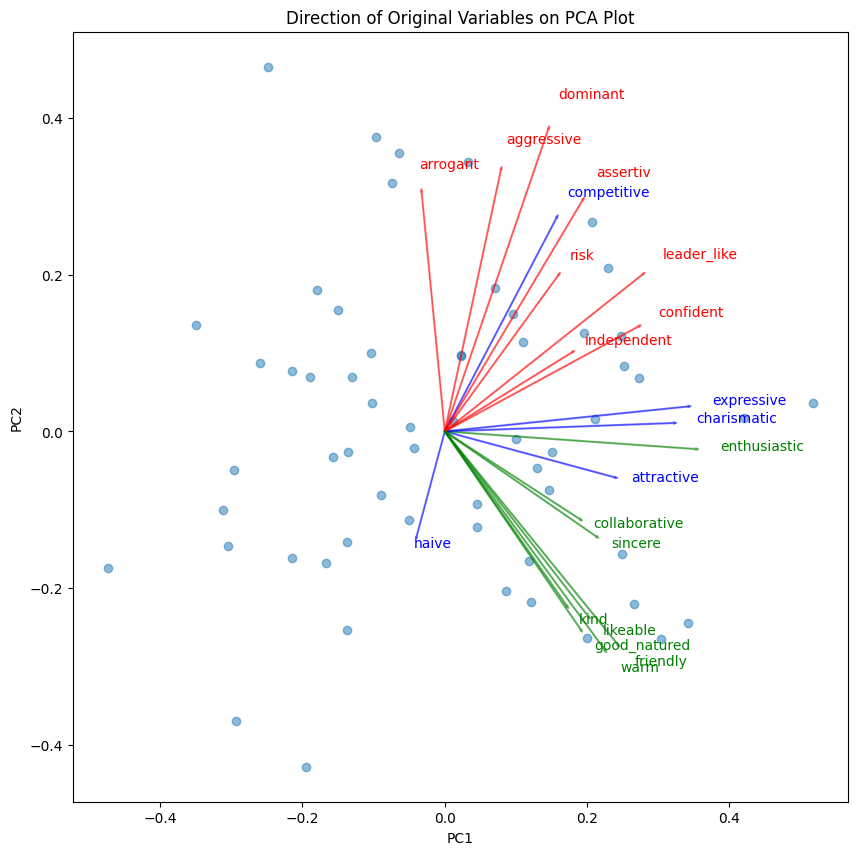

In [15]:
import matplotlib.pyplot as plt

pca_2d = PCA(n_components=2)
pca_2d.fit(train_labels.drop(columns="subj_id"))

# Get the principal components
components = pca_2d.components_

# Big axes
plt.figure(figsize=(10, 10))

# Create a scatter plot of the PCA scores
plt.scatter(pca.transform(train_labels.drop(columns="subj_id"))[:, 0], pca.transform(train_labels.drop(columns="subj_id"))[:, 1], alpha=0.5)

# Define a dictionary to map dimensions to colors
dim_color_dict = {
    'agentic': 'r',
    'communal': 'g',
    'unknown': 'b',
}

# Plot the direction of each variable
for i, var in enumerate(train_labels.drop(columns="subj_id").columns):
    # Get the color for the current dimension from the dictionary
    color = dim_color_dict.get(variable_to_dimension[var], 'b')  # Default to 'b' if the dimension is not in the dictionary
    plt.arrow(0, 0, components[0, i], components[1, i], color=color, alpha=0.5)
    plt.text(components[0, i] * 1.1, components[1, i] * 1.1, var, color=color)

# Set the x and y axis labels
plt.xlabel('PC1')
plt.ylabel('PC2')

# Set the title of the plot
plt.title('Direction of Original Variables on PCA Plot')

# Show the plot
plt.show()

Interestingly enough, the loadings for the label variables are clearly separated in an agentic cluster and a communal cluster. This is consistent with the Dual Perception Model, which states that the two dimensions are logically independent.

Moreover, we could assign a basic dimension to the unknown variables by looking at the position of their loadings. This way, `naive`, `attractive`, `charismatic` and `expressive` could be considered as communal, while `competitive` could be considered as agentic.

In [25]:
# Load the validation data
devel_labels = labels[labels["subj_id"].isin(partitions[partitions["Partition"] == "devel"]["Id"])]

# Encode the validation data
encoded_data = pca_2d.transform(devel_labels.drop(columns="subj_id"))

# Decode the encoded data
decoded_data = pca_2d.inverse_transform(encoded_data)

# Compute the error
error = np.mean(np.square(devel_labels.drop(columns="subj_id").values - decoded_data))

print(f"Mean Squared Error: {error}")

# Compute the pearson correlation between the original and decoded data
correlation = np.corrcoef(devel_labels.drop(columns="subj_id").values.flatten(), decoded_data.flatten())[0, 1]

print(f"Pearson Correlation: {correlation}")

Mean Squared Error: 0.001658661491770204
Pearson Correlation: 0.9425407578504242


We can also check that the PCA 2D model is able to generalize to the devel set, obtaining a low mean squared error and high Pearson correlation between the predicted label reconstruction and the actual labels.

This motivates the use of PCA as dimensionality reduction technique for the labels. We can now train a model using the PCA components as features and then use the inverse transform to obtain final label predictions.

In [16]:
# Create a copy of the labels dataframe
pca_labels = labels.copy()

# Apply PCA transformation on the labels data
pca_transformed = pca.transform(pca_labels.drop(columns="subj_id"))

# Add PC1 and PC2 components to the pca_labels dataframe
pca_labels['PC1'] = pca_transformed[:, 0]
pca_labels['PC2'] = pca_transformed[:, 1]

# Display the pca_labels dataframe
pca_labels[['subj_id', 'PC1', 'PC2']]

,subj_id,PC1,PC2
2,2,0.207483,0.266910
3,3,-0.296324,-0.049414
6,9,-0.138677,-0.017686
7,10,-0.089853,0.075267
8,13,0.067850,-0.153043
...,...,...,...
170,224,0.420920,0.017695
171,225,-0.298162,0.107163
172,226,-0.117430,-0.299841
173,227,-0.008396,-0.191736


In [17]:
# Save pca labels
pca_labels.to_csv(f"{DATA_FOLDER}/pca_labels.csv", index=False)

However, there is still an amount of variance that is not accounted by this model. We can check the actual independence between the agentic and communal labels by plotting their correlations.

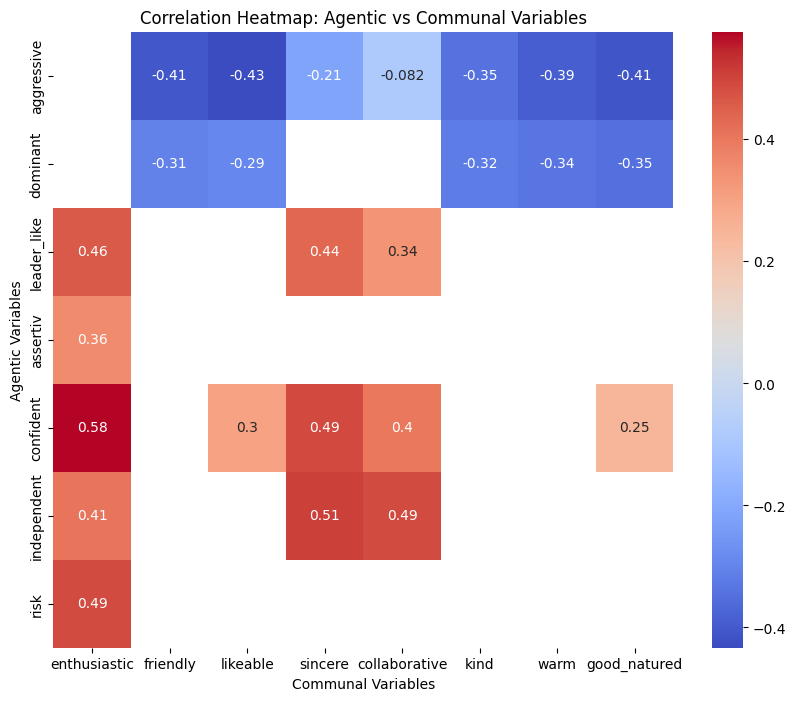

In [17]:
# Select the agentic and communal variables
agentic_vars = ['aggressive', 'dominant', 'leader_like', 'assertiv', 'confident', 'independent', 'risk']
communal_vars = ['enthusiastic', 'friendly', 'likeable', 'sincere', 'collaborative', 'kind', 'warm', 'good_natured']

# Create a subset of the correlation dataframe with only the agentic and communal variables
agentic_communal_corr = corr.loc[agentic_vars, communal_vars]

# Filter out the variables that are not significantly correlated (mask is a numpy.ndarray)
mask_df = pd.DataFrame(mask, index=corr.columns, columns=corr.columns)
agentic_communal_corr = agentic_communal_corr.where(mask_df.loc[agentic_vars, communal_vars])

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(agentic_communal_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Agentic vs Communal Variables')
plt.xlabel('Communal Variables')
plt.ylabel('Agentic Variables')
plt.show()

As predicted, there are  significant positive and negative correlations between variables in both basic dimensions. This means that, at least for this dataset, the two fundamental dimensions are not completely independent.

Based on this, I think that the model should try to predict the joint distribution of the two dimensions, rather than predicting them independently. This could be done by training a single model that predicts the two dimensions at once.

In [18]:
from sklearn.feature_selection import mutual_info_regression

# Create a dictionary to store the mutual information scores
mi_scores = {}

# Loop through the agentic variables
for agentic_var in agentic_vars:
    # Loop through the communal variables
    for communal_var in communal_vars:
        # Calculate the mutual information score between the agentic and communal variables
        mi_score = mutual_info_regression(train_labels[agentic_var].values.reshape(-1, 1), train_labels[communal_var].values)
        # Store the mutual information score in the dictionary
        mi_scores[(agentic_var, communal_var)] = mi_score

# Convert the dictionary to a DataFrame
mi_scores_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['MI Score'])

# Sort the DataFrame by the mutual information score
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

# Display the DataFrame
mi_scores_df

,MI Score
"(confident, enthusiastic)",0.262846
"(independent, collaborative)",0.206795
"(independent, warm)",0.180897
"(confident, sincere)",0.160563
"(independent, friendly)",0.139425
"(confident, kind)",0.137838
"(independent, sincere)",0.134418
"(confident, warm)",0.128911
"(aggressive, kind)",0.111664
"(aggressive, good_natured)",0.110369


The mutual information scores also show that there are variables from the two different dimensions that are informative of each other. This is another argument in favour of the idea of training a single model for the two dimensions.

We can try a simple bi-dimensional Linear Regression that predicts the PCA scores of a sample using the features that work best on the baseline paper.

The ViT-FER features used in conjunction with a GRU model obtained a mean $\rho$ of $0.3042 \pm 0.634$ on the baseline paper. We can try to to predict the PCA features using the mean ViT-FER feature for each subject and a Linear Regression over the subjects and the PCA features.

In [19]:
example = pd.read_csv(f"{DATA_FOLDER}/feature_segments/vit-fer/0.csv")
example

,timestamp,subj_id,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,0,0,-0.127925,0.213739,-0.176485,-0.021834,0.069745,-0.075725,-0.093511,-0.089916,...,0.486614,0.150709,0.129230,0.120281,-0.419520,-0.570963,-0.016254,-0.306994,0.163203,-0.325518
1,500,0,0.010051,0.058639,-0.137175,0.071006,0.054067,-0.188229,-0.177380,0.172126,...,0.561635,0.152708,0.143541,0.180833,-0.145185,-0.549434,-0.118547,-0.374653,0.297651,-0.473292
2,1000,0,0.022934,0.004203,0.007741,0.217876,0.049729,-0.143373,-0.157193,0.178165,...,0.620997,0.158368,-0.112244,0.082620,-0.218470,-0.303985,-0.269805,-0.422381,0.356707,-0.359476
3,1500,0,-0.136698,0.064658,-0.228275,0.065734,0.076104,-0.105917,-0.185012,0.085361,...,0.522131,0.153890,0.087267,0.083052,-0.272198,-0.615711,-0.093969,-0.356851,0.176661,-0.243531
4,2000,0,-0.369484,-0.055079,-0.166254,-0.012559,0.185401,-0.042422,0.090831,0.159148,...,0.470457,0.165870,0.355821,-0.028872,-0.064380,-0.373111,-0.134267,-0.279807,0.036983,-0.101196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,28500,0,0.226044,0.160042,0.030249,0.133987,-0.027849,-0.265336,-0.232068,0.188594,...,0.706296,0.147228,-0.090358,0.079919,-0.150215,-0.373066,-0.230935,-0.416017,0.457540,-0.404566
58,29000,0,0.212205,0.182566,0.027795,0.242742,-0.042071,-0.259015,-0.221008,0.173177,...,0.654454,0.140811,0.007404,0.044451,-0.183441,-0.329615,-0.225131,-0.426585,0.382387,-0.455187
59,29500,0,0.053238,0.143107,0.089027,0.205084,-0.088199,-0.146956,-0.230605,0.193601,...,0.734916,0.155661,-0.186348,0.075228,-0.115180,-0.267095,-0.239877,-0.346521,0.431781,-0.448382
60,30000,0,0.214265,0.205032,0.036949,0.207131,-0.062045,-0.245933,-0.247960,0.244555,...,0.682028,0.140274,-0.150309,0.090499,-0.236628,-0.300990,-0.218098,-0.517635,0.314206,-0.493331


In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def load_dataset(feature_name, subj_id):
    subj_data = pd.read_csv(f"{DATA_FOLDER}/feature_segments/{feature_name}/{subj_id}.csv")
    # Return the mean feature for the subject
    return subj_data.drop(columns=["timestamp", "subj_id"]).mean()

example_feature = 'vit-fer'
example_subj_id = 0
example_data = load_dataset(example_feature, example_subj_id)
example_data

0      0.094112
1      0.134273
2     -0.048669
3      0.134187
4     -0.016464
         ...   
763   -0.390396
764   -0.179780
765   -0.368786
766    0.305041
767   -0.348262
Length: 768, dtype: float64

In [21]:
features = pd.DataFrame()

for subj_id in labels['subj_id']:
    subj_data = load_dataset(example_feature, subj_id)
    features = pd.concat([features, subj_data.T], axis=1)

features = features.T
features.index = labels['subj_id']

features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
subj_id,,,,,,,,,,,,,,,,,,,,,
2,-0.295787,0.137378,-0.287858,-0.043868,-0.009343,0.045661,0.131075,-0.135283,-0.298521,0.442225,...,-0.094404,0.184503,0.309460,0.045599,0.042442,-0.280005,0.067893,0.039891,-0.119250,0.094673
3,0.327985,0.200130,0.115123,0.418256,-0.067113,0.144225,-0.184181,0.165062,-0.314291,0.288855,...,0.613904,0.186861,-0.118297,0.027260,-0.306702,-0.227307,-0.222085,-0.334630,-0.041004,-0.306686
9,0.058828,0.376403,-0.610339,-0.200579,-0.125421,0.062288,-0.229520,-0.276259,-0.050491,0.287130,...,0.127499,0.202439,-0.120687,0.240690,-0.301504,-0.306268,-0.069094,-0.088786,0.260816,-0.272273
10,-0.192423,0.171389,-0.319514,-0.028474,-0.108395,0.052788,-0.025187,0.050064,-0.406038,0.396485,...,0.400462,0.219232,-0.028267,-0.016552,-0.029335,-0.245582,0.003630,-0.097631,-0.036943,-0.058059
13,-0.084152,0.095772,-0.198740,-0.125663,-0.049600,0.102146,-0.154586,0.042933,-0.244217,0.517249,...,0.361766,0.215563,0.011812,0.162676,0.052059,-0.191264,-0.092545,-0.154148,0.197120,-0.123635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,-0.059641,0.088675,-0.221886,-0.004727,-0.147502,0.075843,0.068188,0.063707,-0.199114,0.080007,...,0.119961,0.237409,-0.002178,-0.118188,-0.029032,0.007954,-0.014233,0.096886,-0.215147,0.048180
225,0.247023,0.362476,-0.174208,0.103945,-0.063950,-0.134595,-0.055746,0.052531,-0.359444,0.582561,...,0.507144,0.178505,-0.233942,0.082988,-0.261800,-0.469278,0.036837,-0.242864,0.003492,-0.256842
226,0.231285,0.182526,0.068687,0.319442,-0.149254,-0.309432,-0.283126,0.189068,-0.216383,0.505554,...,0.672413,0.148833,-0.099201,0.101840,-0.179084,-0.446032,-0.186403,-0.361804,0.150247,-0.374953


In [22]:
train_features, devel_features = features.loc[partitions[partitions["Partition"] == "train"]["Id"]], features.loc[partitions[partitions["Partition"] == "devel"]["Id"]]

train_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
subj_id,,,,,,,,,,,,,,,,,,,,,
2,-0.295787,0.137378,-0.287858,-0.043868,-0.009343,0.045661,0.131075,-0.135283,-0.298521,0.442225,...,-0.094404,0.184503,0.309460,0.045599,0.042442,-0.280005,0.067893,0.039891,-0.119250,0.094673
3,0.327985,0.200130,0.115123,0.418256,-0.067113,0.144225,-0.184181,0.165062,-0.314291,0.288855,...,0.613904,0.186861,-0.118297,0.027260,-0.306702,-0.227307,-0.222085,-0.334630,-0.041004,-0.306686
14,-0.059888,0.233547,-0.320886,-0.050954,0.091669,-0.013121,-0.056731,0.000105,-0.023068,0.229101,...,0.020867,0.222781,-0.004001,0.175197,-0.079157,0.000315,-0.037478,-0.159098,0.064411,-0.047858
17,-0.177702,0.337575,-0.221537,-0.123579,-0.122046,0.117339,0.212303,0.198340,-0.237724,0.439938,...,0.245836,0.247187,0.069175,0.134058,-0.079879,-0.538731,0.000010,-0.044411,0.132843,-0.147369
18,-0.074378,0.095794,-0.167091,-0.209260,-0.044306,0.228520,-0.001571,0.017107,0.007263,0.155722,...,0.159255,0.192188,-0.178667,0.089877,-0.130788,0.057756,-0.018218,-0.139166,0.340484,-0.154608
19,0.114782,0.134016,-0.046237,0.041188,0.037027,-0.069043,-0.099253,0.271209,-0.276229,0.337337,...,0.416173,0.172811,-0.051813,0.141838,-0.205850,-0.207299,-0.109279,-0.320128,0.085020,-0.354611
37,-0.239224,0.129965,-0.280615,0.088669,0.005316,0.060479,-0.093888,0.074540,-0.159735,0.408581,...,0.536553,0.203880,-0.027773,0.065314,-0.076974,-0.091296,-0.064797,-0.042248,-0.040077,-0.162629
42,-0.304770,-0.018857,-0.400091,-0.138443,0.181715,0.244945,0.014955,-0.046710,-0.043124,0.453303,...,-0.055717,0.196574,-0.126009,0.086315,0.080857,-0.012239,0.099190,0.024636,0.322712,0.008190
43,0.128402,0.217456,-0.095078,0.107044,-0.065829,-0.299727,-0.221925,0.151394,-0.192001,0.642084,...,0.587163,0.170600,0.040888,0.050317,-0.180576,-0.597472,-0.147528,-0.293552,0.204704,-0.224652


In [23]:
# Build a linear regressor on PC1 and PC2 using the features

# Create a linear regression model
model = LinearRegression()

train_pca_labels = pca_labels[pca_labels["subj_id"].isin(partitions[partitions["Partition"] == "train"]["Id"])]

# Fit the model on the training data
model.fit(train_features, train_pca_labels[['PC1', 'PC2']])

# Predict the PC1 and PC2 values for the validation data
predicted_pca_labels = model.predict(devel_features)

predicted_pca_labels = pd.DataFrame(predicted_pca_labels, columns=['PC1', 'PC2'], index=devel_features.index)

predicted_pca_labels

,PC1,PC2
subj_id,,
9,0.017151,-0.167005
10,-0.134066,-0.088856
13,0.100256,-0.159155
20,0.017872,0.279967
25,-0.017041,0.226177
27,0.069921,0.141498
28,-0.121721,-0.097350
30,0.004367,0.051568
32,-0.061858,-0.102516


Firstly we can visualize the predicted and true PCA features to check how the model performs on the PCA space.

Mean Squared Error: 0.04499634000628263
R-squared: -0.24119357185356743


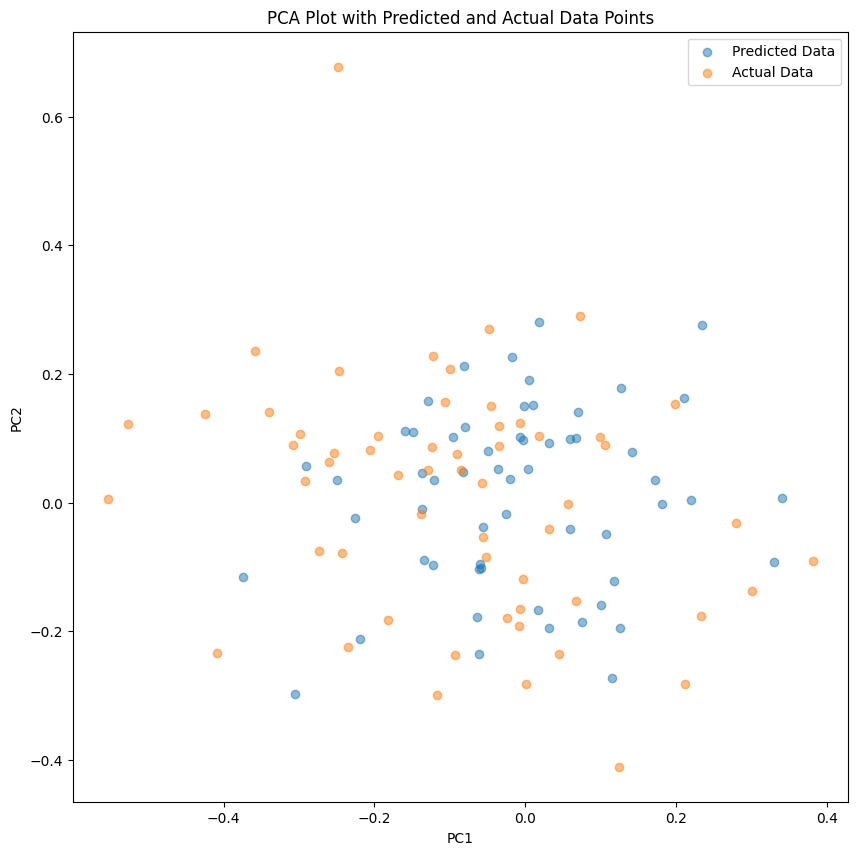

In [26]:
# Compute regression metrics
from sklearn.metrics import mean_squared_error, r2_score

devel_pca_labels = pca_labels[pca_labels["subj_id"].isin(partitions[partitions["Partition"] == "devel"]["Id"])]

# Calculate the Mean Squared Error on both PC1 and PC2
mse = mean_squared_error(devel_pca_labels[['PC1', 'PC2']], predicted_pca_labels)
# Calculate the R-squared value on both PC1 and PC2
r2 = r2_score(devel_pca_labels[['PC1', 'PC2']], predicted_pca_labels)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the predicted points and the actual points on the PCA plot using different colors
plt.figure(figsize=(10, 10))
#plt.scatter(pca.transform(train_labels.drop(columns="subj_id"))[:, 0], pca.transform(train_labels.drop(columns="subj_id"))[:, 1], alpha=0.5, label='Train Data')
plt.scatter(predicted_pca_labels['PC1'], predicted_pca_labels['PC2'], alpha=0.5, label='Predicted Data')
plt.scatter(pca.transform(devel_labels.drop(columns="subj_id"))[:, 0], pca.transform(devel_labels.drop(columns="subj_id"))[:, 1], alpha=0.5, label='Actual Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA Plot with Predicted and Actual Data Points')
plt.show()

The predictions lie approximately on the same space as the original features, but there are clear errors. In particular, the obtained MSE is 0.045, which is decent but not optimal.

Let's see how the model behaves on the original feature space.

In [27]:
# Use the PCA inverse transform to get the predicted labels
predicted_labels = pca_2d.inverse_transform(predicted_pca_labels)
print(type(predicted_labels))

skip_columns = ["attractive", "charismatic", "competitive", "expressive", "naive"]

mse = {}
# Calculate the Mean Squared Error between the predicted and actual labels
for i, var in enumerate(devel_labels.drop(columns="subj_id").columns):
    if var in skip_columns:
        continue
    mse[var] = mean_squared_error(devel_labels[var], predicted_labels.values[:, i])

mse = pd.Series(mse)
print(mse)



# Calculate the Pearson correlation between the predicted and actual labels for each of the variables
correlations = {}
for i, var in enumerate(devel_labels.drop(columns="subj_id").columns):
    if var in skip_columns:
        continue
    correlation = pearsonr(devel_labels[var], predicted_labels.values[:, i])[0]
    correlations[var] = correlation

correlations = pd.Series(correlations)
print(correlations)

# Mean correlation
mean_correlation = correlations.mean()
print(f"Mean Pearson Correlation: {mean_correlation}")

<class 'pandas.core.frame.DataFrame'>
aggressive       0.007611
arrogant         0.004780
dominant         0.006249
enthusiastic     0.011804
friendly         0.006274
leader_like      0.005293
likeable         0.005300
assertiv         0.006403
confident        0.005649
independent      0.002841
risk             0.004825
sincere          0.004132
collaborative    0.003535
kind             0.004935
warm             0.006577
good_natured     0.004837
dtype: float64
aggressive       0.301740
arrogant         0.415142
dominant         0.251728
enthusiastic     0.133637
friendly         0.321408
leader_like      0.248880
likeable         0.333093
assertiv         0.165225
confident        0.130962
independent      0.220695
risk             0.148586
sincere          0.258751
collaborative    0.327477
kind             0.283041
warm             0.200477
good_natured     0.408927
dtype: float64
Mean Pearson Correlation: 0.2593605387095698


We can see that the inverse transform of the predicted PCA labels performs decently taking into account the simplifications made on the pipeline. The mean $\rho% is 0.2594. Next, we can try to repeat the baseline GRU but predicting each of the PCs and then combining the predictions for the inverse transform, or build a GRU that predicts both PCs at the same time.